In [1]:
import os
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST, FashionMNIST
from torchvision.utils import save_image

import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
num_epochs = 10
batch_size = 128
lr = 1e-3
img_size = 28 

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

dataloader = DataLoader(
    FashionMNIST('../../data', download = True,transform=transform),
    batch_size=batch_size,
    shuffle=True
)


In [5]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3),
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x) 
        decoded = self.decoder(encoded) 
        return encoded, decoded
    

In [6]:
autoencoder = Autoencoder().to(device)
optimizer = torch.optim.Adam(
    autoencoder.parameters(), lr=lr, weight_decay=1e-5
)
criterion = nn.MSELoss()


In [7]:
def add_noise(img):
    noise = torch.randn(img.size()) * 0.2
    noisy_img = img + noise
    return noisy_img

In [8]:
for epoch in range(num_epochs):
    for data in dataloader:
        img, _ = data
        noise_x = add_noise(img)
        noise_x = noise_x.view(-1, 28*28).to(device)
        img = img.view(-1, 28*28).to(device)

        encoded, decoded = autoencoder(noise_x)
        loss = criterion(decoded, img)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print('epoch[{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, loss.item()))

epoch[1/10], loss:0.6034
epoch[2/10], loss:0.5912
epoch[3/10], loss:0.6428
epoch[4/10], loss:0.6221
epoch[5/10], loss:0.6269
epoch[6/10], loss:0.6176
epoch[7/10], loss:0.6096
epoch[8/10], loss:0.5923
epoch[9/10], loss:0.6252
epoch[10/10], loss:0.6158


In [9]:
testSet = FashionMNIST(
    root      = '../../data', 
    train     = False, #test데이터셋
    download  = True,
    transform = transforms.ToTensor()
)

In [10]:
sample_data = testSet.data[0].view(-1, 28*28)
sample_data = sample_data.type(torch.FloatTensor)/255.

In [11]:
original_x = sample_data[0]
noisy_x = add_noise(original_x).to(device)
_, recovered_x = autoencoder(noisy_x) 


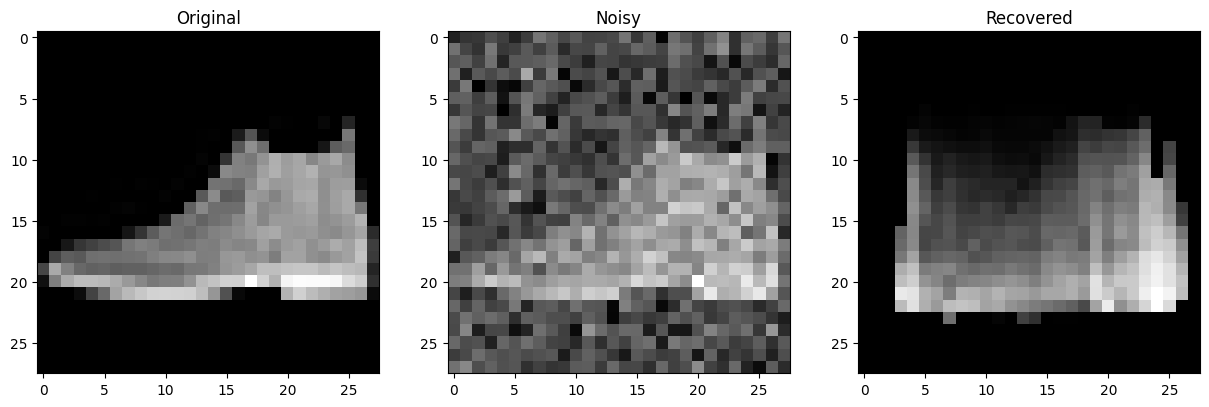

In [12]:
f, a = plt.subplots(1, 3, figsize=(15, 15))

# 시각화를 위해 넘파이 행렬로 바꿔줍니다.
original_img = np.reshape(original_x.to("cpu").data.numpy(), (28, 28))
noisy_img = np.reshape(noisy_x.to("cpu").data.numpy(), (28, 28))
recovered_img = np.reshape(recovered_x.to("cpu").data.numpy(), (28, 28))

# 원본 사진
a[0].set_title('Original')
a[0].imshow(original_img, cmap='gray')

# 오염된 원본 사진
a[1].set_title('Noisy')
a[1].imshow(noisy_img, cmap='gray')

# 복원된 사진
a[2].set_title('Recovered')
a[2].imshow(recovered_img, cmap='gray')

plt.show()